# Exercise 5 - Variational quantum eigensolver


## Historical background

During the last decade, quantum computers matured quickly and began to realize Feynman's initial dream of a computing system that could simulate the laws of nature in a quantum way. A 2014 paper first authored by Alberto Peruzzo introduced the **Variational Quantum Eigensolver (VQE)**, an algorithm meant for finding the ground state energy (lowest energy) of a molecule, with much shallower circuits than other approaches.[1] And, in 2017, the IBM Quantum team used the VQE algorithm to simulate the ground state energy of the lithium hydride molecule.[2]

VQE's magic comes from outsourcing some of the problem's processing workload to a classical computer. The algorithm starts with a parameterized quantum circuit called an ansatz (a best guess) then finds the optimal parameters for this circuit using a classical optimizer. The VQE's advantage over classical algorithms comes from the fact that a quantum processing unit can represent and store the problem's exact wavefunction, an exponentially hard problem for a classical computer. 

This exercise 5 allows you to realize Feynman's dream yourself, setting up a variational quantum eigensolver to determine the ground state and the energy of a molecule. This is interesting because the ground state can be used to calculate various molecular properties, for instance the exact forces on nuclei than can serve to run molecular dynamics simulations to explore what happens in chemical systems with time.[3]


### References

1. Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." Nature communications 5.1 (2014): 1-7.
2. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242-246.
3. Sokolov, Igor O., et al. "Microcanonical and finite-temperature ab initio molecular dynamics simulations on quantum computers." Physical Review Research 3.1 (2021): 013125.

## Introduction

For the implementation of VQE, you will be able to make choices on how you want to compose your simulation, in particular focusing on the ansatz quantum circuits.
This is motivated by the fact that one of the important tasks when running VQE on noisy quantum computers is to reduce the loss of fidelity (which introduces errors) by finding the most compact quantum circuit capable of representing the ground state.
Practically, this entails to minimizing the number of two-qubit gates (e.g. CNOTs) while not loosing accuracy.

<div class="alert alert-block alert-success">

<b>Goal</b> 

Find the shortest ansatz circuits for representing accurately the ground state of given problems. Be creative!
    
<b>Plan</b> 
    
First you will learn how to compose a VQE simulation for the smallest molecule and then apply what you have learned to a case of a larger one.
    
**1. Tutorial -  VQE for H$_2$:** familiarize yourself with VQE and select the best combination of ansatz/classical optimizer by running statevector simulations.

**2. Final Challenge - VQE for LiH:** perform similar investigation as in the first part but restricting to statevector simulator only. Use the qubit number reduction schemes available in Qiskit and find the optimal circuit for this larger system. Optimize the circuit and use your imagination to find ways to select the best building blocks of parameterized circuits and compose them to construct the most compact ansatz circuit for the ground state, better than the ones already available in Qiskit.  

</div>


<div class="alert alert-block alert-danger">

Below is an introduction to the theory behind VQE simulations. You don't have to understand the whole thing before moving on. Don't be scared!

</div>



## Theory

Here below is the general workflow representing how the molecular simulations using VQE are performed on quantum computers.

<img src="resources/workflow.png" width=800 height= 1400/>

The core idea hybrid quantum-classical approach is to outsource to **CPU (classical processing unit)** and **QPU (quantum processing unit)** the parts that they can do best. The CPU takes care of listing the terms that need to be measured to compute the energy and also optimizing the circuit parameters. The QPU implements a quantum circuit representing the quantum state of a system and measures the energy. Some more details are given below:

**CPU** can compute efficiently the energies associated to electron hopping and interactions (one-/two-body integrals by means of a Hartree-Fock calculation) that serve to represent the total energy operator, Hamiltonian. The [Hartree–Fock (HF) method](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method#:~:text=In%20computational%20physics%20and%20chemistry,system%20in%20a%20stationary%20state.) efficiently computes an approximate grounds state wavefunction by assuming that the latter can be represented by a single Slater determinant (e.g. for H$_2$ molecule in STO-3G basis with 4 spin-orbitals and qubits, $|\Psi_{HF} \rangle = |0101 \rangle$ where electrons occupy the lowest energy spin-orbitals). What QPU does later in VQE is finding a quantum state (corresponding circuit and its parameters) that can also represent other states associated missing electronic correlations (i.e. $\sum_i c_i |i\rangle$ states in  $|\Psi \rangle = c_{HF}|\Psi_{HF} \rangle + \sum_i c_i |i\rangle $ where $i$ is a bitstring). 

After a HF calculation, operators in the Hamiltonian are mapped to measurements on a QPU using fermion-to-qubit transformations (see Hamiltonian section below). One can further analyze the properties of the system to reduce the number of qubits or shorten the ansatz circuit:

- For Z2 symmetries and two-qubit reduction, see [Bravyi *et al*, 2017](https://arxiv.org/abs/1701.08213v1).
- For entanglement forging, see [Eddins *et al.*, 2021](https://arxiv.org/abs/2104.10220v1).
- For the adaptive ansatz see, [Grimsley *et al.*,2018](https://arxiv.org/abs/1812.11173v2), [Rattew *et al.*,2019](https://arxiv.org/abs/1910.09694), [Tang *et al.*,2019](https://arxiv.org/abs/1911.10205). You may use the ideas found in those works to find ways to shorten the quantum circuits.

**QPU** implements quantum circuits (see Ansatzes section below), parameterized by angles $\vec\theta$, that would represent the ground state wavefunction by placing various single qubit rotations and entanglers (e.g. two-qubit gates). The quantum advantage lies in the fact that QPU can efficiently represent and store the exact wavefunction, which becomes intractable on a classical computer for systems that have more than a few atoms.  Finally, QPU measures the operators of choice (e.g. ones representing a Hamiltonian).

Below we go slightly more in mathematical details of each component of the VQE algorithm. It might be also helpful if you watch our [video episode about VQE](https://www.youtube.com/watch?v=Z-A6G0WVI9w).


### Hamiltonian 

Here we explain how we obtain the operators that we need to measure to obtain the energy of a given system.
These terms are included in the molecular Hamiltonian defined as:
$$
\begin{aligned}
\hat{H} &=\sum_{r s} h_{r s} \hat{a}_{r}^{\dagger} \hat{a}_{s} \\
&+\frac{1}{2} \sum_{p q r s} g_{p q r s} \hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}+E_{N N}
\end{aligned}
$$
with
$$
h_{p q}=\int \phi_{p}^{*}(r)\left(-\frac{1}{2} \nabla^{2}-\sum_{I} \frac{Z_{I}}{R_{I}-r}\right) \phi_{q}(r)
$$
$$
g_{p q r s}=\int \frac{\phi_{p}^{*}\left(r_{1}\right) \phi_{q}^{*}\left(r_{2}\right) \phi_{r}\left(r_{2}\right) \phi_{s}\left(r_{1}\right)}{\left|r_{1}-r_{2}\right|} 
$$

where the $h_{r s}$  and $g_{p q r s}$ are the one-/two-body integrals (using the Hartree-Fock method) and $E_{N N}$ the nuclear repulsion energy. 
The one-body integrals represent the kinetic energy of the electrons and their interaction with nuclei. 
The two-body integrals represent the electron-electron interaction.
The $\hat{a}_{r}^{\dagger}, \hat{a}_{r}$ operators represent creation and annihilation of electron in spin-orbital $r$ and require mappings to operators, so that we can measure them on a quantum computer.
Note that VQE minimizes the electronic energy so you have to retrieve and add the nuclear repulsion energy $E_{NN}$ to compute the total energy. 
    


So, for every non-zero matrix element in the $ h_{r s}$ and $g_{p q r s}$ tensors, we can construct corresponding Pauli string (tensor product of Pauli operators) with the following fermion-to-qubit transformation. 
For instance, in Jordan-Wigner mapping for an orbital $r = 3$, we obtain the following Pauli string:
$$
\hat a_{3}^{\dagger}= \hat \sigma_z \otimes \hat \sigma_z \otimes\left(\frac{ \hat \sigma_x-i \hat \sigma_y}{2}\right) \otimes 1 \otimes \cdots \otimes 1
$$
where $\hat \sigma_x, \hat \sigma_y, \hat \sigma_z$ are the well-known Pauli operators. The tensor products of $\hat \sigma_z$ operators are placed to enforce the fermionic anti-commutation relations.
A representation of the Jordan-Wigner mapping between the 14 spin-orbitals of a water molecule and some 14 qubits is given below:

<img src="resources/mapping.png" width=600 height= 1200/>


Then, one simply replaces the one-/two-body excitations (e.g. $\hat{a}_{r}^{\dagger} \hat{a}_{s}$, $\hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}$) in the Hamiltonian by corresponding Pauli strings (i.e. $\hat{P}_i$, see picture above). The resulting operator set is ready to be measured on the QPU.
For additional details see [Seeley *et al.*, 2012](https://arxiv.org/abs/1208.5986v1).

### Ansatzes

There are mainly 2 types of ansatzes you can use for chemical problems. 

- **q-UCC ansatzes** are physically inspired, and roughly map the electron excitations to quantum circuits. The q-UCCSD ansatz (`UCCSD`in Qiskit) possess all possible single and double electron excitations. The paired double q-pUCCD (`PUCCD`) and singlet q-UCCD0 (`SUCCD`) just consider a subset of such excitations (meaning significantly shorter circuits) and have proved to provide good results for dissociation profiles. For instance, q-pUCCD doesn't have single excitations and the double excitations are paired as in the image below.
- **Heuristic ansatzes (`TwoLocal`)** were invented to shorten the circuit depth but still be able to represent the ground state. 
As in the figure below, the R gates represent the parametrized single qubit rotations and $U_{CNOT}$ the entanglers (two-qubit gates). The idea is that after repeating certain $D$-times the same block (with independent parameters) one can reach the ground state. 

For additional details refer to [Sokolov *et al.* (q-UCC ansatzes)](https://arxiv.org/abs/1911.10864v2) and [Barkoutsos *et al.* (Heuristic ansatzes)](https://arxiv.org/pdf/1805.04340.pdf).

<img src="resources/ansatz.png" width=700 height= 1200/>



### VQE

Given a Hermitian operator $\hat H$ with an unknown minimum eigenvalue $E_{min}$, associated with the eigenstate $|\psi_{min}\rangle$, VQE provides an estimate $E_{\theta}$, bounded by $E_{min}$:

\begin{align*}
    E_{min} \le E_{\theta} \equiv \langle \psi(\theta) |\hat H|\psi(\theta) \rangle
\end{align*}  

where $|\psi(\theta)\rangle$ is the trial state associated with $E_{\theta}$. By applying a parameterized circuit, represented by $U(\theta)$, to some arbitrary starting state $|\psi\rangle$, the algorithm obtains an estimate $U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle$ on $|\psi_{min}\rangle$. The estimate is iteratively optimized by a classical optimizer by changing the parameter $\theta$ and minimizing the expectation value of $\langle \psi(\theta) |\hat H|\psi(\theta) \rangle$. 

As applications of VQE, there are possibilities in molecular dynamics simulations, see [Sokolov *et al.*, 2021](https://arxiv.org/abs/2008.08144v1), and excited states calculations, see [Ollitrault *et al.*, 2019](https://arxiv.org/abs/1910.12890) to name a few.

<div class="alert alert-block alert-danger">
 
<b> References for additional details</b> 

For the qiskit-nature tutorial that implements this algorithm see [here](https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html)
but this won't be sufficient and you might want to look on the [first page of github repository](https://github.com/Qiskit/qiskit-nature) and the [test folder](https://github.com/Qiskit/qiskit-nature/tree/main/test) containing tests that are written for each component, they provide the base code for the use of each functionality.

</div>

## Part 1: Tutorial - VQE for H$_2$ molecule 



In this part, you will simulate H$_2$ molecule using the STO-3G basis with the PySCF driver and Jordan-Wigner mapping.
We will guide you through the following parts so then you can tackle harder problems.
    


#### 1. Driver

The interfaces to the classical chemistry codes that are available in Qiskit are called drivers.
We have for example `PSI4Driver`, `PyQuanteDriver`, `PySCFDriver` are available. 

By running a driver (Hartree-Fock calculation for a given basis set and molecular geometry), in the cell below, we obtain all the necessary information about our molecule to apply then a quantum algorithm.

In [1]:
from qiskit_nature.drivers import PySCFDriver

molecule = "H .0 .0 .0; H .0 .0 0.739"
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

<div class="alert alert-block alert-danger">
    
<b> Tutorial questions 1</b> 
    
Look into the attributes of `qmolecule` and answer the questions below.

    
1. We need to know the basic characteristics of our molecule. What is the total number of electrons in your system?
2. What is the number of molecular orbitals?
3. What is the number of spin-orbitals?
3. How many qubits would you need to simulate this molecule with Jordan-Wigner mapping?
5. What is the value of the nuclear repulsion energy?

You can find the answers at the end of this notebook.
</div>

In [2]:
# WRITE YOUR CODE BETWEEN THESE LINES - START
n_el = qmolecule.num_alpha + qmolecule.num_beta
print("What is the total number of electrons in your system? " + str(n_el))
n_mo = qmolecule.num_molecular_orbitals
print("What is the number of molecular orbitals? " + str(n_mo))
n_so = 2 * qmolecule.num_molecular_orbitals
print("What is the number of spin-orbitals? " + str(n_so))
n_q = 2* qmolecule.num_molecular_orbitals
print("How many qubits would you need to simulate this molecule with Jordan-Wigner mapping? " + str(n_q))
e_nn = qmolecule.nuclear_repulsion_energy
print("What is the value of the nuclear repulsion energy? " + str(e_nn))

# WRITE YOUR CODE BETWEEN THESE LINES - END

What is the total number of electrons in your system? 2
What is the number of molecular orbitals? 2
What is the number of spin-orbitals? 4
How many qubits would you need to simulate this molecule with Jordan-Wigner mapping? 4
What is the value of the nuclear repulsion energy? 0.7160720039512857


#### 2. Electronic structure problem

You can then create an `ElectronicStructureProblem` that can produce the list of fermionic operators before mapping them to qubits (Pauli strings).

In [3]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
problem = ElectronicStructureProblem(driver)

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

#### 3. QubitConverter

Allows to define the mapping that you will use in the simulation. You can try different mapping but 
we will stick to `JordanWignerMapper` as allows a simple correspondence: a qubit represents a spin-orbital in the molecule.

In [4]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

#### 4. Initial state
As we described in the Theory section, a good initial state in chemistry is the HF state (i.e. $|\Psi_{HF} \rangle = |0101 \rangle$). We can initialize it as follows:

In [5]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          


#### 5. Ansatz
One of the most important choices is the quantum circuit that you choose to approximate your ground state.
Here is the example of qiskit circuit library that contains many possibilities for making your own circuit.

In [26]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choose the ansatz
ansatz_type = "SUCCD"

# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entanglement = 'full'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 3
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write your own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

print(ansatz)

global phase: 0
      ┌───┐ ┌─────┐┌───┐┌───┐┌───┐┌───┐┌────────────────┐┌───┐┌───┐ ┌───┐ ┌───┐»
q_0: ─┤ X ├─┤ SDG ├┤ H ├┤ X ├┤ X ├┤ X ├┤ RZ(-0.25*t[0]) ├┤ X ├┤ X ├─┤ X ├─┤ H ├»
     ┌┴───┴┐└┬───┬┘└───┘└─┬─┘└─┬─┘└─┬─┘└────────────────┘└─┬─┘└─┬─┘ └─┬─┘ ├───┤»
q_1: ┤ SDG ├─┤ H ├────────■────┼────┼──────────────────────┼────┼─────■───┤ H ├»
     └┬───┬┘┌┴───┴┐┌───┐       │    │                      │    │   ┌───┐ ├───┤»
q_2: ─┤ X ├─┤ SDG ├┤ H ├───────■────┼──────────────────────┼────■───┤ H ├─┤ S ├»
      ├───┤ └─────┘└───┘            │                      │  ┌───┐┌┴───┴┐├───┤»
q_3: ─┤ H ├─────────────────────────■──────────────────────■──┤ H ├┤ SDG ├┤ H ├»
      └───┘                                                   └───┘└─────┘└───┘»
«     ┌───┐┌─────┐┌───┐┌───┐┌───┐┌───┐┌───────────────┐┌───┐┌───┐┌───┐ ┌───┐ »
«q_0: ┤ S ├┤ SDG ├┤ H ├┤ X ├┤ X ├┤ X ├┤ RZ(0.25*t[0]) ├┤ X ├┤ X ├┤ X ├─┤ H ├─»
«     ├───┤├─────┤├───┤└─┬─┘└─┬─┘└─┬─┘└───────────────┘└─┬─┘└─┬─┘└─┬─┘ ├───┤ »
«q_1: ┤ S ├┤ SDG ├

#### 6. Backend
This is where you specify the simulator or device where you want to run your algorithm.
We will focus on the `statevector_simulator` in this challenge.


In [7]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

#### 7. Optimizer

The optimizer guides the evolution of the parameters of the ansatz so it is very important to investigate the energy convergence as it would define the number of measurements that have to be performed on the QPU.
A clever choice might reduce drastically the number of needed energy evaluations.

In [48]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'COBYLA'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

#### 8. Exact eigensolver
For learning purposes, we can solve the problem exactly with the exact diagonalization of the Hamiltonian matrix so we know where to aim with VQE.
Of course, the dimensions of this matrix scale exponentially in the number of molecular orbitals so you can try doing this for a large molecule of your choice and see how slow this becomes. 
For very large systems you would run out of memory trying to store their wavefunctions.

In [9]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

# The targeted electronic energy for H2 is -1.85336 Ha
# Check with your VQE result.

Exact electronic energy -1.8533636186720364
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.853363618672
  - computed part:      -1.853363618672
~ Nuclear repulsion energy (Hartree): 0.716072003951
> Total ground state energy (Hartree): -1.137291614721
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.39650761]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.39650761]
    - computed part:      [0.0  0.0  1.39650761]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.
                 (debye): [0.0  0.0  0.00000001]  Total: 0.00000001
 


#### 9. VQE and initial parameters for the ansatz
Now we can import the VQE class and run the algorithm.

In [10]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 500,
    'eigenstate': array([ 5.55839219e-07+4.33667242e-05j, -2.54817228e-04+1.69136374e-04j,
       -1.41198727e-05+1.07852951e-05j, -2.98933473e-05+3.34001403e-05j,
       -9.30756867e-06-2.69271113e-06j,  9.59165537e-01+2.59526293e-01j,
        4.01826666e-04-2.39628624e-04j, -6.72818471e-08+1.34512394e-07j,
        3.66141410e-08-2.52535990e-08j, -7.66350067e-04+4.00786325e-04j,
       -1.08531209e-01-2.94523377e-02j,  8.41316477e-05-1.50598909e-05j,
        3.82451399e-06-3.01452469e-06j,  1.24046236e-04-9.64048191e-05j,
       -3.11599148e-05-1.51052025e-05j, -1.17678002e-04+1.17115410e-05j]),
    'eigenvalue': -1.8533628495566552,
    'optimal_parameters': {   ParameterVectorElement(θ[20]): -0.31980898480092,
                              ParameterVectorElement(θ[21]): 1.1822559282436655,
                              ParameterVectorElement(θ[22]): 1.0536585009278732,
                              ParameterVector

#### 9. Scoring function 
We need to judge how good are your VQE simulations, your choice of ansatz/optimizer.
For this, we implemented the following simple scoring function:

$$ score = N_{CNOT}$$

where $N_{CNOT}$ is the number of CNOTs. 
But you have to reach the chemical accuracy which is $\delta E_{chem} = 0.004$ Ha $= 4$ mHa, which may be hard to reach depending on the problem. 
You have to reach the accuracy we set in a minimal number of CNOTs to win the challenge. 
The lower the score the better!

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,TwoLocal,4,24,"['ry', 'rz']",cx,full,3.0,0.000769,True,18
1,COBYLA,TwoLocal,4,24,"['ry', 'rz']",cx,full,3.0,0.000769,True,18
2,COBYLA,TwoLocal,4,24,"['ry', 'rx']",cx,full,3.0,0.000769,True,18
3,COBYLA,TwoLocal,4,24,"['ry', 'rx']",ccx,full,3.0,0.000769,True,18
4,COBYLA,QuantumCircuit,4,24,NaN,NaN,NaN,NaN,0.000769,True,3
5,COBYLA,UCCSD,4,24,NaN,NaN,NaN,NaN,0.000769,True,56
6,COBYLA,PUCCD,4,24,NaN,NaN,NaN,NaN,0.000769,True,48
7,COBYLA,SUCCD,4,24,NaN,NaN,NaN,NaN,0.000769,True,48
8,L_BFGS_B,SUCCD,4,24,NaN,NaN,NaN,NaN,0.000769,True,48
9,SPSA,SUCCD,4,24,NaN,NaN,NaN,NaN,0.000769,True,48


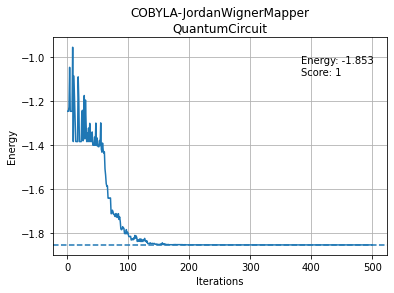

In [49]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

<div class="alert alert-block alert-danger">
    
<b>Tutorial questions 2</b> 

Experiment with all the parameters and then:

1. Can you find your best (best score) heuristic ansatz (by modifying parameters of `TwoLocal` ansatz) and optimizer?
2. Can you find your best q-UCC ansatz (choose among `UCCSD, PUCCD or SUCCD` ansatzes) and optimizer?
3. In the cell where we define the ansatz, 
   can you modify the `Custom` ansatz by placing gates yourself to write a better circuit than your `TwoLocal` circuit? 

For each question, give `ansatz` objects.
Remember, you have to reach the chemical accuracy $|E_{exact} - E_{VQE}| \leq 0.004 $ Ha $= 4$ mHa.
    
</div>



In [46]:
# WRITE YOUR CODE BETWEEN THESE LINES - START
def construct_superposition(qc, n):
    for i in range(n-1):
        qc.h(i)
        
def construct_alternate_superposition(qc, n):
    for i in range(n-1):
        if i%2 == 0:
            qc.h(i)


# Example of how to write your own circuit
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
# Define the variational parameter
theta = Parameter('a')
n = qubit_op.num_qubits

construct_alternate_superposition(qc, n)
# Make an empty quantum circuit
qc = QuantumCircuit(qubit_op.num_qubits)
qubit_label = 0

qc.cx(0,1)

ansatz = qc
ansatz.compose(init_state, front=True, inplace=True)

print(ansatz)
# WRITE YOUR CODE BETWEEN THESE LINES - END

     ┌───┐     
q_0: ┤ X ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
     ┌───┐└───┘
q_2: ┤ X ├─────
     └───┘     
q_3: ──────────
               


## Part 2: Final Challenge - VQE for LiH molecule 


In this part, you will simulate LiH molecule using the STO-3G basis with the PySCF driver.

</div>
    
<div class="alert alert-block alert-success">

<b>Goal</b> 

Experiment with all the parameters and then find your best ansatz. You can be as creative as you want!

For each question, give `ansatz` objects as for Part 1. Your final score will be based only on Part 2.
    
</div>

Be aware that the system is larger now. Work out how many qubits you would need for this system by retrieving the number of spin-orbitals. 

### Reducing the problem size

You might want to reduce the number of qubits for your simulation:
- you could freeze the core electrons that do not contribute significantly to chemistry and consider only the valence electrons. Qiskit  already has this functionality implemented. So inspect the different transformers in `qiskit_nature.transformers`  and find the one that performs the freeze core approximation.
- you could use `ParityMapper` with `two_qubit_reduction=True` to eliminate 2 qubits.
- you could reduce the number of qubits by inspecting the symmetries of your Hamiltonian. Find a way to use `Z2Symmetries` in Qiskit.

### Custom ansatz 

You might want to explore the ideas proposed in [Grimsley *et al.*,2018](https://arxiv.org/abs/1812.11173v2), [H. L. Tang *et al.*,2019](https://arxiv.org/abs/1911.10205), [Rattew *et al.*,2019](https://arxiv.org/abs/1910.09694), [Tang *et al.*,2019](https://arxiv.org/abs/1911.10205). 
You can even get try machine learning algorithms to generate best ansatz circuits.

### Setup the simulation

Let's now run the Hartree-Fock calculation and the rest is up to you!

<div class="alert alert-block alert-danger">

<b>Attention</b> 

We give below the `driver`, the `initial_point`, the `initial_state` that should remain as given.
You are free then to explore all other things available in Qiskit.
So you have to start from this initial point (all parameters set to 0.01):
    
`initial_point = [0.01] * len(ansatz.ordered_parameters)`
    or
`initial_point = [0.01] * ansatz.num_parameters`

and your initial state has to be the Hartree-Fock state:
    
`init_state = HartreeFock(num_spin_orbitals, num_particles, converter)`
    
For each question, give `ansatz` object.
Remember you have to reach the chemical accuracy $|E_{exact} - E_{VQE}| \leq 0.004 $ Ha $= 4$ mHa.

</div>

In [192]:
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()
from qiskit_nature.transformers import FreezeCoreTransformer
freezeCoreTransfomer = FreezeCoreTransformer()
#qmolecule = freezeCoreTransfomer.transform(qmolecule)

In [ ]:
# WRITE YOUR CODE BETWEEN THESE LINES - START
from qiskit_nature.circuit.library import UVCCSD
from qiskit.opflow.primitive_ops import Z2Symmetries

def construct_custom_1():
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    #construct_superposition(qc, n)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    construct_superposition(qc, n)
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)
    return ansatz


def construct_TwoLocal():
    # Single qubit rotations that are placed on all qubits with independent parameters

    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entanglement = 'full'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 6
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = True
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                        entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
                      #entangler_map=entangler_map, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
    return ansatz



n_el = qmolecule.num_alpha + qmolecule.num_beta
print("What is the total number of electrons in your system? " + str(n_el))
n_mo = qmolecule.num_molecular_orbitals
print("What is the number of molecular orbitals? " + str(n_mo))
n_so = 2 * qmolecule.num_molecular_orbitals
print("What is the number of spin-orbitals? " + str(n_so))
n_q = 2* qmolecule.num_molecular_orbitals
print("How many qubits would you need to simulate this molecule with Jordan-Wigner mapping? " + str(n_q))
e_nn = qmolecule.nuclear_repulsion_energy
print("What is the value of the nuclear repulsion energy? " + str(e_nn))



#problem = ElectronicStructureProblem(driver)
problem = ElectronicStructureProblem(driver ,q_molecule_transformers=[freezeCoreTransfomer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]


# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

#converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1, 1])
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1, 1])

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)
print(qubit_op.num_qubits)

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

print("num particles " + str(num_particles))
print("num spin orbitals " + str(num_spin_orbitals))

#qubit_op = Z2Symmetries.two_qubit_reduction(qubit_op, num_particles)
print(qubit_op.num_qubits)


#ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
#ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)

# Define the variational parameter
ansatz = construct_TwoLocal()
#ansatz = construct_custom_1()

#print(ansatz)


# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result.eigenvalue)
# WRITE YOUR CODE BETWEEN THESE LINES - END

'Evaluation: 487, Energy: -0.803722531581136, Std: 0.0'

In [198]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 334.
Feel free to submit your answer.



In [199]:
# Submit your answer. You can re-submit at any time.
from qc_grader import submit_ex5
submit_ex5(ansatz,qubit_op,result,freeze_core)

Submitting your answer for ex5. Please wait...
Success 🎉! Your answer has been submitted.


## Answers for Part 1

<div class="alert alert-block alert-danger">

<b>Questions</b> 
    
Look into the attributes of `qmolecule` and answer the questions below.

    
1. We need to know the basic characteristics of our molecule. What is the total number of electrons in your system?
2. What is the number of molecular orbitals?
3. What is the number of spin-orbitals?
3. How many qubits would you need to simulate this molecule with Jordan-Wigner mapping?
5. What is the value of the nuclear repulsion energy?
    
</div>

<div class="alert alert-block alert-success">

<b>Answers </b> 

1. `n_el = qmolecule.num_alpha + qmolecule.num_beta`
    
2. `n_mo = qmolecule.num_molecular_orbitals`
    
3. `n_so = 2 * qmolecule.num_molecular_orbitals`
    
4. `n_q = 2* qmolecule.num_molecular_orbitals`
    
5. `e_nn = qmolecule.nuclear_repulsion_energy`
    
    
</div>

## Additional information

**Created by:** Igor Sokolov, Junye Huang, Rahul Pratap Singh

**Version:** 1.0.0